In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from pathlib import Path
import random
import sys
from skimage.segmentation import  clear_border,watershed
from skimage import  color
from scipy import ndimage
from skimage.morphology import reconstruction
import imageio.core.util
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from sklearn.cluster import MeanShift
from PIL import Image
from PIL import ImageFilter

def ignore_warnings(*args, **kwargs):
    pass
imageio.core.util._precision_warn = ignore_warnings

In [23]:
# Get image root path str(Path(file_path).parent.resolve()) + 
image_src_path = str(".\Sequences")
# individual image path example
path_cell = str(image_src_path + "\\01\\t000.tif")
path_seg = str(image_src_path + "\\01_GT\\SEG\\man_seg088.tif")
path_tra = str(image_src_path + "\\01_GT\\TRA\\man_track013.tif")
# Read as gray
cell = cv2.imread(path_cell, cv2.IMREAD_GRAYSCALE)
cell_seg = cv2.imread(path_seg, -1)
cell_tra = cv2.imread(path_tra, -1)


In [25]:
def to_binary_image(input_image: np.array, background_potion = 6):
    input = input_image.copy()
    meaningful_range = np.max(input) - np.min(input)
    input = cv2.normalize(input, None, alpha=0, beta=meaningful_range, norm_type=cv2.NORM_MINMAX)
    input[input >= meaningful_range/background_potion] = 255
    input[input < meaningful_range/background_potion] = 0
    return input

def dilate_erode_reduce_noise(input_binary: np.array, kernel = (5,5), iteration = 15):
    '''
    Try Dilate and erode
    1. Dilate the objects first to get rid of the noise inside each objects
    2. erode the objects with same degree to decrease the size to original state
    '''
    input = input_binary.copy()
    input = cv2.dilate(input, kernel, iterations = iteration)
    input = cv2.erode(input, kernel, iterations = iteration)
    return input

def find_coutours_draw(input_gray: np.array):
    '''
    Find all of the coutours of the input image cell and draw the coutours
    '''
    threshold = (np.max(input_gray) - np.min(input_gray))/2
    input_edges = cv2.Canny(input_gray, threshold, threshold)
    # plt.title("input_edges")
    # plt.imshow(input_edges, cmap="gray")
    # plt.show()
    return input_edges

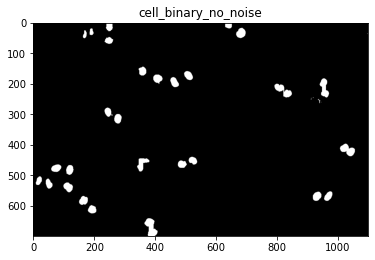

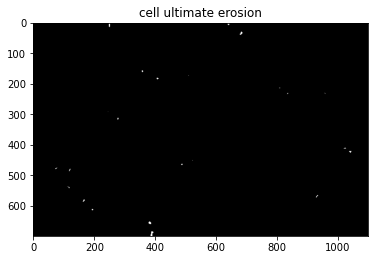

In [60]:
# Turn into np array first
cell = np.array(cell)
# plt.title("cell")
# plt.imshow(cell, cmap="gray")
# plt.show()
# To binary
cell_binary = to_binary_image(cell)
# reduce noise
cell_binary_no_noise = dilate_erode_reduce_noise(cell_binary)
plt.title("cell_binary_no_noise")
plt.imshow(cell_binary_no_noise, cmap="gray")
plt.show()
# get coutours
# cell_binary_coutour = find_coutours_draw(cell_binary_no_noise)
# plt.title("cell_binary_coutour")
# plt.imshow(cell_binary_coutour, cmap="gray")
# plt.show()

kernel = np.ones((17,17),np.uint8)
cell_erode = cv2.erode(cell_binary_no_noise,kernel,iterations=1)
plt.title("cell ultimate erosion")
plt.imshow(cell_erode, cmap="gray")
plt.show()

# cell_r = reconstruction(cell_binary_no_noise,cell_erode,method="erosion")
# plt.imshow(cell_r, cmap="gray")
# plt.show()


In [95]:
cell = cv2.imread(path_cell, cv2.IMREAD_GRAYSCALE)
cell = np.array(cell)
gray = cell
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=1)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0



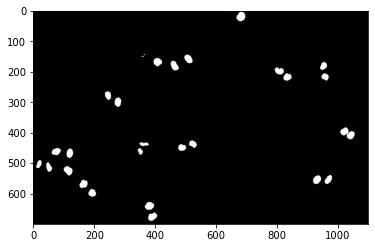

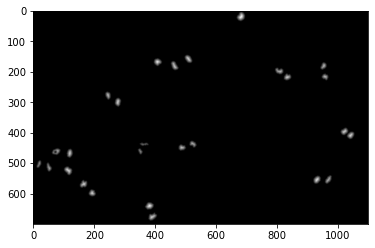

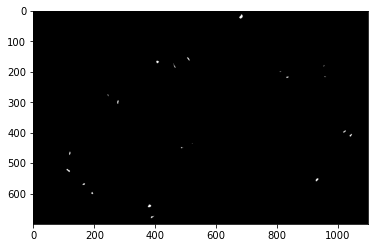

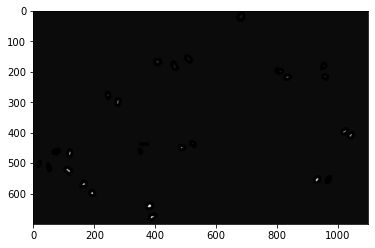

In [96]:
plt.imshow(thresh, cmap="gray")
plt.show()
plt.imshow(dist_transform, cmap="gray")
plt.show()
plt.imshow(sure_fg, cmap="gray")
plt.show()
plt.imshow(markers, cmap="gray")
plt.show()